# 对比性测试

## 概念

### ***CommonNarsese***

- 由[Narsese Grammar (IO Format)](https://github.com/opennars/opennars/wiki/Narsese-Grammar-(Input-Output-Format))定义，
- 在各类NARS(Narsese)实现中，
- 最先产生规范，并最为广泛接受的一种语法

与其它方言、超集的不同点举例：
- 原子词项：
    - 一律使用`$`、`#`、`?`、`^`区分「独立变量」「非独变量」「查询变量」「操作」
    - 一律使用单独的`_`表示「像占位符」
- 复合词项：
    - 一律使用特殊括弧`{词项...}`、`[词项...]`表示「外延集」「内涵集」
    - 一律使用「圆括号+前缀表达式」`(连接符, 词项...)`形式表示「非外延集、内涵集的复合词项」
        - 如`(&, <A --> B>, ^op)`
        - 对「否定」不使用前缀表达式
        - 对其它「二元复合词项」不使用中缀表达式
- 陈述：
    - 一律使用尖括号表示陈述，没有其他选项
        - 如`<A --> B>`
    - 不使用「回顾性等价」`<\>`系词
        - 一律用表义能力等同的「预测性等价」`</>`系词代替
        - 如`<A <\> B>`将表示为`<B </> A>`


## 导入

In [1]:
if !isdefined(Main, :JuNarsese)
    push!(LOAD_PATH, "../src") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "../../JuNarsese/") # 用于直接打开（..上一级目录）
    push!(LOAD_PATH, "src") # 用于VSCode调试（项目根目录起）
    push!(LOAD_PATH, "../JuNarsese/") # 用于VSCode调试（项目根目录起）

    # 自动导入JuNarsese模块
    using JuNarsese
    using JuNarseseParsers
end

JuNarsese v2.5.0


JuNarsese v2.5.0


In [2]:
const UNothing{T} = Union{Nothing, T} where T
const UMissing{T} = Union{Missing, T} where T
UNothing{Int}, UMissing{Exception}

(Union{Nothing, Int64}, Union{Missing, Exception})

## 测试集生成

宏の辅助：自动生成if-elseif-else表达式

In [3]:
"""
自动生成if-elseif-else表达式
使得其中的表达式只有在运行到时才会计算

参数：
- 元组：(条件, 内容)
"""
function generate_ifelseif_expressions(exprs::Vararg{Pair})
    return generate_ifelseif_expressions(nothing, exprs...)
end

"+默认情况"
function generate_ifelseif_expressions(default, exprs::Vararg{Pair})
    blk::Expr = Expr(:block)
    return generate_ifelseif_expressions!(blk, default, exprs...)
end

"""
基于已有的:block表达式，附带默认情况
"""
function generate_ifelseif_expressions!(parent::Expr, default, exprs::Vararg{Pair})

    current_args::Vector = parent.args
    is_first::Bool = true
    for expr_pair::Pair in exprs
        push!(
            current_args, 
            Expr(
                is_first ? begin
                    is_first = false
                    :if
                end : :elseif,
                expr_pair.first, 
                expr_pair.second
            )
        )
        current_args = current_args[end].args # 跳到if/elseif表达式的末尾
    end

    # 默认情况：增加else
    !isnothing(default) && push!(
        current_args, 
        default
    )

    return parent
end

"""
基于已有的:block表达式
"""
function generate_ifelseif_expressions!(parent::Expr, exprs::Vararg{Pair})
    generate_ifelseif_expressions!(parent, nothing, exprs...)
end

"""
宏の形式
注意：传入的每个Pair表达式都是`Expr(:call, :(=>), 前, 后)`的形式
"""
macro generate_ifelseif_expressions(default, exprs::Vararg{Expr})
    # 直接获取第二、第三个参数
    return generate_ifelseif_expressions(
        default,
        (
            expr.args[2] => expr.args[3]
            for expr in exprs
        )...
    ) |> esc
end

d = Dict(
    1 => 1, 2 => 2, 3 => 3
)

@show generate_ifelseif_expressions(0, d...)

@show r = rand(1:4)

# 最多睡3秒
@generate_ifelseif_expressions 4 (sleep(1);r==1) => 2 (sleep(1);r==2) => 3 (sleep(1);r==3) => 4

generate_ifelseif_expressions(0, d...) = quote
    if 2
        2
    elseif 3
        3
    elseif 1
        1
    else
        0
    end
end
r = rand(1:4) = 3


4

In [4]:
"""
宏的等价函数
用于自动
1. 构造随机数
2. 生成`if-elseif-else`表达式
"""
function rand_macro(exprs...)::Union{Symbol, Expr}

    # 预先计算表达式数量
    n = length(exprs)

    # 可能是封装到数组里面去了
    if n == 1
        exprs = exprs[1].args
        n = length(exprs)
    end

    # 只有一个⇒优化：直接返回
    if n == 1
        return exprs[1] # 可能是Symbol
    end
    # @assert n > 1 "随机选择至少需要两个备选结果"

    rand_variable::Symbol = Symbol(":rand_n:")

    # 构造代码块
    blk::Expr = Expr(
        :block,
        :(local $rand_variable = rand(1:$n))
    )

    return generate_ifelseif_expressions!(
        blk,
        (
            :($rand_variable == $i) => expr
            for (i, expr) in enumerate(exprs)
        )...
    )
end

"""
一个用于随机选择代码执行的宏
避免「在随机选择之前，预先计算出所有的备选结果」
"""
macro rand(exprs...)
    rand_macro(exprs...) |> esc
end

# 最多睡一秒
@rand sleep(0.5) sleep(0.75) sleep(1)

随机词项发生器

In [5]:
randstring(n) = *(rand(Char.(97:122), n)...)

randomName() = randstring(rand(1:10))

"随机产生一个原子词项"
function randomAtom(depth = 0, width = 0)
    type = @rand [
        Word
        IVar
        DVar
        QVar
        Operator
    ]
    type(randomName())
end

"随机产生一个陈述"
function randomStatement(depth = 5, width = 2)
    return @rand [
        randomTStatement(depth - 1, width)
        randomSStatement(depth - 1, width)
    ]
end

"""
随机产生一个面向词项的陈述
- 这里的陈述只能是「一等公民词项」
    - 适配OpenJunars
"""
function randomTStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomAtom : randomFOTerm
    type = @rand [
        Inheritance
        Similarity
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomSStatement(depth = 5, width = 2)
    constructor = depth <= 0 ?
        randomTStatement : randomStatement
    type = @rand [
        Implication
        Equivalence
    ]
    type(constructor(depth - 1), constructor(depth - 1))
end

function randomImage(depth = 5, width = 2)
    type = @rand [
        ExtImage,
        IntImage
    ]
    terms = [randomTerm(depth - 1,width) for _ in 1:rand(1:width)]
    relation_index::Integer = rand(1:(length(terms)+1))
    type(relation_index, terms...)
end

function randomTermSets(depth = 5, width = 2)
    type = @rand [
        TermProduct
        ExtSet
        IntSet
        ExtIntersection
        IntIntersection
    ]
    type((
        randomTerm(depth - 1,width)
        for _ in 1:rand(1:width)
    )...)
end


"随机产生一个复合词项(不包括陈述)"
function randomCompound(depth = 5, width = 5)
    return @rand [
        randomTermSet2s(depth - 1, width)
        randomTermSets(depth - 1, width)
        randomImage(depth - 1, width)
    ]
end

"迁移自OpenJunars：「一等公民词项」=原子+复合，而非陈述"
function randomFOTerm(depth = 5, width = 5)
    return @rand [
        randomAtom(depth - 1, width)
        randomCompound(depth - 1, width)
    ]
end

""
function randomTermSet2s(depth = 5, width = 2)
    type = @rand [
        ExtDifference
        IntDifference
    ]
    type(randomTerm(depth - 1), randomTerm(depth - 1))
end

""
function randomStatementSets(depth = 5, width = 2)
    type = @rand [
        Conjunction
        Disjunction
        ParConjunction
        SeqConjunction
    ]
    type(randomStatement(depth - 1), randomStatement(depth - 1))
end

#=
    IntDifference
=#

function randomTerm(depth=3, width=3)
    depth <= 0 ?
    randomAtom() : @rand [
        randomCompound(depth-1, width)
        randomStatement(depth - 1, width)
        Negation(randomStatement(depth-1, width))
    ]
end

randomTruth() = JuNarsese.default_precision_truth(rand(0.01:0.01:0.99, 2)...)
randomBudget() = JuNarsese.default_precision_budget(rand(0.01:0.01:0.99, 3)...)
randomTense() = @rand [
    TensePast
    TensePresent
    TenseFuture
    TenseEternal
]

randomStamp() = JuNarsese.StampBasic{randomTense()}() # 暂仅支持随机时态

function random_wrap_sentence(term::Term)
    type = @rand [
        SentenceJudgement
        SentenceQuestion
        SentenceGoal
        SentenceQuest
    ]
    type(term; truth = randomTruth(), stamp = randomStamp())
end

function random_wrap_task(sentence::ASentence)
    TaskBasic(sentence; budget = randomBudget())
end

randomSentence(depth=3, width=3) = random_wrap_sentence(randomStatement(depth-1, width))
randomTask(depth=3, width=3) = random_wrap_task(randomSentence(depth-1, width))


function randomNarsese(depth=3, width=3)
    return @rand [
        randomTerm(depth, width)
        randomSentence(depth, width)
        randomTask(depth, width)
    ]
end

[
    randomNarsese(5, 5)
    for _ in 1:10
]

10-element Vector{Any}:
 <(/, _, $no, emv) <-> ?tnawqgdsu>? :|:
 (\, _, (--, <^cwrnzfyaow --> caioc>), <<$s --> ^acfnwplzv> ==> <irthdmzjgd <-> ?uvj>>)
 <$mk --> (~, ?wlk, #vcqygstfe)>. :|: %0.49;0.29%
 $0.22;0.88;0.94$ <(~, #cjtqloxv, ^zxaorrl) <-> (~, $qcbvrgiwmx, ?yihtox)>@ :/:
 $0.34;0.51;0.4$ <$c --> ^avdhdtqa>. :\: %0.92;0.57%
 (/, [^exz, ^mpb, #qdksezmhs, ^x, $ybxewkurs], <#mnkltk --> ^uvx>, {?avqqz, ^dtkt, llppglbu, #zvsovvut}, _, <<?b --> qpdhdpusvd> <=> <m --> ?fbuzyqaf>>, <<?olpfcoj <-> rfx> ==> <$oul <-> ^tpm>>)
 <#fvo <-> ?iumwn>! :|: %0.31;0.76%
 $0.29;0.41;0.58$ <<fiksgd --> $m> ==> <$lvbj <-> $xaslwyvr>>! %0.49;0.3%
 $0.41;0.47;0.13$ <$efnmjxw <-> $zxlsuripgf>! :|: %0.83;0.12%
 (--, <(/, _, ?whi, ?xmi) <-> (/, a, $xtcwxvthsl, _, #zezuvnfk)>)

生成测试集

In [6]:
# 生成测试集
D = 10 # 嵌套深度
W = 10 # 项数广度
N = 500 # 词项数量

# 展示一个
@show randomNarsese(D, W)

test_terms = [
    randomTerm(D, W) # 先生成随机词项，然后再将部分词项修改成语句、任务
    for _ in 1:N
]

randomNarsese(D, W) = <(~, <<^mj <-> mjsmaz> ==> <cdebatq --> $mgmoypqogv>>, (*, (--, <<$yhzhtcwjlm --> ^qma> ==> <$bodiyqjcaj --> $hzzhbkb>>), (/, #e, _))) --> #qzglesw>@


500-element Vector{AbstractTerm}:
 (--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)
 (--, <{(--, <(\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)
 (|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])
 <<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>
 <<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>
 (--, <(~, (--, <<<?cpzaa --> txb> <=> <^je

## 评估函数

#### 导入数据分析工具：DataFrames

In [7]:
using DataFrames

测试：使用具名元组直接添加行

In [8]:
d = DataFrame(
    string = Vector{String}(),
    parsed = Vector{Any}(),
    time = Vector{Float64}(),
    error = Vector{UMissing{Exception}}()
)

push!(
    d,
    (
        string = "1",#test_strings[i],
        parsed = "1",#parse(test_strings[i]),
        time = 0.0,
        error = missing
    )
)

Row,string,parsed,time,error
,String,Any,Float64,Exception?
1,1,1,0.0,missing


#### 构造测试用表

In [9]:
test_set::DataFrame = DataFrame(
    original_term = test_terms,
    string = test_terms .|> string,
)

Row,original_term,string
,Abstract…,String
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)"
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)"
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])"
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>"
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)"
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}"
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcidoppl, bhrka)> <=> <(~, tzkpxef, #ubpqv

In [10]:
# 动态增加数据：只需要设置属性✅
test_set.complexity = test_set.original_term .|> JuNarsese.get_syntactic_complexity

test_set

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}",76
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcido

#### 增加「非CommonNarsese语法」：更能体现出解析器通用性的语法

1. 无连接符复合词项⇒乘积：`(A, B)`⇔`(*, A, B)`

In [11]:
# 无连接符复合词项⇒乘积 #
# 📝直接使用「布尔索引」对切片进行操作

# 使用 map() 函数对 test_set_extra1 中的 string 列进行操作，返回一个新数据表
# 将其中符合正则表达式 r"\(\*\W*," 的字符串替换为 "(*,"
test_set_extra1_string = map(test_set.string) do x
    replace(x, r"\(\*\W*," => "(*,")
end

# 使用「布尔索引」来选择不等于原始 string 列的值
# 并将这些值替换为经过操作后的新值
# 注意：.≠ 运算符用于逐元素比较两个数组，生成一个布尔型数组
# test_set_extra1.string[test_set_extra1! .≠ test_set_extra1.string] = test_set_extra1![test_set_extra1! .≠ test_set_extra1.string]

#【20230819 20:07:04】现在直接把「能改成新格式」的数据增加到主数据集中
indices = test_set_extra1_string .≠ test_set.string # 索引：只获取「会被改变的词项」

test_set_extra1 = test_set[indices, :] |> deepcopy

test_set_extra1.string = test_set_extra1_string[indices]

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra1
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}",76
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcido

2. 随机添加空白字符：空格` `、换行`\r`、回车`\n`、换页`\f`、水平制表符`\t`、垂直制表符`\v`

In [12]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Abstract…,String,Int64
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}",76
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcido

3. 按一定比例随机选取词项，提升成**语句**、**任务**（遵循CommonNarsese语法）
- 这样可以保留语法复杂度等信息

In [13]:
# 随机选取行
rand_sentences = DataFrame(rand(eachrow(test_set), 100))
rand_tasks = DataFrame(rand(eachrow(test_set), 100
))

# 打包，原地赋值
rand_sentences.original_term = rand_sentences.original_term .|> random_wrap_sentence
rand_tasks.original_term = rand_tasks.original_term .|> random_wrap_sentence .|> random_wrap_task

# 更新字符串
rand_sentences.string = string.(rand_sentences.original_term)
rand_tasks.string = string.(rand_tasks.original_term)

test_set = [ # 拼接
    test_set # 原本
    rand_sentences
    rand_tasks
]

Row,original_term,string,complexity
,Any,String,Int64
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}",76
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcidoppl, b

In [14]:
indices = 1:100

# 原数据框中对应部分
origin = test_set[indices, :]

# 将空格随机替换成换行、回车、换页、水平制表符、垂直制表符
test_set_extra2_string = map(origin.string) do x
    # 随机次数
    local s, n = x, 1+length(x)÷5
    for i in 1:n
        # 随机索引
        local index = x |> eachindex |> collect |> rand
        # 模拟用户在空白符周围输入各种用于格式化对齐的空格、制表符等
        # ↑此举对「不预处理去掉所有空白符，而是把空白符当做语义token」的解析器友好
        isspace(s[index]) || continue
        s = s[begin:index] * (
            @rand [
                " "
                "\r"
                "\n"
                "\f"
                "\t"
                "\v"
            ]
        ) * s[nextind(s, index):end]
    end
    return s
end

test_set_extra2 = test_set[indices, :] |> deepcopy

test_set_extra2.string = test_set_extra2_string

# 将新数据添加进原测试集中
test_set = [ # 直接使用向量的语法拼接，无需concat
    test_set
    test_set_extra2[origin.string .≠ test_set_extra2_string, :]
]

Row,original_term,string,complexity
,Any,String,Int64
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}","{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?qgv> ==> <syubifft <-> ^wykfaeptmv>>, (--, <<?jmhszwjox <-> $xq> ==> <?hnq <-> ^rqk>>), (\\, $cqjxnkyt, ?wjsvqvmfg, _), _, (&, ?lxr, qneppk, #qsbc, ^xqltzy))>, <(-, <?rutgayk --> #tiyvan>, <$l <-> #zlumincnta>) <-> (\\, <wfcxgvmk --> $g>, (--, <<^h <-> kigl> ==> <$oqbziisml --> $ddczhmrfm>>), _, (--, <^j --> ?pzthvmqt>), (&, bxmrvtdzl))>, <<(-, cyfqofyc, hf) <-> (/, se, _, ^myysaqf)> <=> <(/, _, ^lgbqvb, $fsvdnheett, ^oozlpqdgl) --> ad>>}",76
8,"(--, <<<<[^aweyylx, fuqp, ^nqdqpafvc] <-> (~, $wjcidoppl, b

#### 构造评估函数

In [15]:
"""
构造一个测试解析器的函数，
输入解析器、测试集、测试次数，
输出解析结果、每次解析的耗时时长、总时长和总平均时长

参数「测试集test_set」
- original_term: 原初词项
- term_string: 字符串
- complexity: 词项语法复杂度（使用JuNarsese计算）
"""
function testParser!(parser, test_set::DataFrame, n = 1)

    # datas
    datas::NamedTuple = ( # 具名元组
        parsed = Vector{UMissing{Any}}(),
        time = Vector{UMissing{Float64}}(),
        error = Vector{UMissing{Exception}}(),
    )

    for term_string::String in test_set.string
        try
            # 解析&计时
            parse_time = @elapsed (
                parsed_term = parser(term_string)
            )
            # 存储数据
            push!(datas.parsed, parsed_term)
            push!(datas.time, parse_time)
            push!(datas.error, missing)
        catch e
            # @error "已跳过解析错误的项，错误信息为：" term_string e
            push!(datas.parsed, missing)
            push!(datas.time, missing)
            push!(datas.error, e)
        end
    end
    
    # 根据errors汇报错误
    errors = filter(!ismissing, datas.error)
    if length(errors) > 0
        @error "$(parser)：以下$(length(errors))项解析错误：" errors
    end

    # 向数据框填充新数据
    data_names::Tuple = (:parsed, :time, :error)
    for data_name::Symbol in data_names
        setproperty!(
            test_set, data_name, 
            getproperty(datas, data_name)
        )
    end
    # 返回新的数据框
    return test_set
end

testParser!

试运行

In [16]:
# 测试字符串解析器
results = testParser!(StringParser_ascii, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",0.604549,missing
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",0.162793,missing
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",0.0271853,missing
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,0.0006514,missing
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",0.0117096,missing
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",0.0381783,missing
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {

In [17]:
# 导入OpenJunars
isdefined(Main, :Junars) || begin
    push!(LOAD_PATH, "../../../OpenJunars/")
    import Junars
end
# 测试OpenJunars
parser = Junars.parse_term
parsed_term = parser("<A --> B>")
@info "OpenJunars解析结果:" parsed_term typeof(parsed_term)

┌ Info: OpenJunars解析结果:
│   parsed_term = "<A-->B>"
│   typeof(parsed_term) = Junars.Gene.Inheritance
└ @ Main h:\A137442\Develop\AGI\NARS\_Project\JuNarseseParsers\test\comparative_tests.ipynb:9


In [18]:
testParser!(Junars.parse_term, copy(test_set[1:100, :]))

Row,original_term,string,complexity,parsed,time,error
,Any,String,Int64,Any,Float64?,Exception?
1,"(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)","(--, <(*, (--, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> $rngvjhptji>)",24,"""(¬,<\\$rngvjhptji<->(*,(¬,<(&&,<#zwloj-->?lfr>,<^gkdrn-->?p>)==><\\$gpcm-->^qvmdsyph>>),(¬,<<#zibtde<->^ek><=><?cfzwplbyz<->?jlzbfqlhas>>),(~,<<ser-->#ryv>==><?qqilfcvbom<->?uquwnhe>>,<<#hezwvmarkq-->#dk>==><#wcyb<->?ipm>>))>)""",0.928241,missing
2,"(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)","(--, <{(--, <(\\, ^r, $uxxnfahpa, rg, _) <-> (-, rbcxzxmtth, #ipprsy)>), <<#aaxtebb --> ?e> <=> <jvc --> ^cvtmcpiv>>} <-> pnfr>)",16,"""(¬,<pnfr<->{(¬,<(-,rbcxzxmtth,#ipprsy)<->(\\\\,^r,\\$uxxnfahpa,rg,_)>),<<#aaxtebb-->?e><=><jvc-->^cvtmcpiv>>}>)""",0.119861,missing
3,"(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])","(|, [(--, <<<$koogkayl <-> #mtic> ==> <#m --> w>> <=> <<^r <-> $tuurjshd> <=> <yicpytysk --> hitxza>>>), <<<?rxt --> $umuyq> ==> <byngzxar <-> g>> <=> <<wjdmjsvve --> ?kokg> ==> <?jsjbyr <-> ?q>>>])",24,"""(|,[(¬,<<<#mtic<->\\$koogkayl>==><#m-->w>><=><<\\$tuurjshd<->^r><=><yicpytysk-->hitxza>>>),<<<?rxt-->\\$umuyq>==><byngzxar<->g>><=><<wjdmjsvve-->?kokg>==><?jsjbyr<->?q>>>])""",0.136125,missing
4,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,<<{<<#aeixsdb <-> ^dbevdivii> <=> <?dm <-> #fh>>} <-> ?hwymgtgx> <=> <?aibpcyzde <-> #blgiquigc>>,8,"""<<#blgiquigc<->?aibpcyzde><=><?hwymgtgx<->{<<#aeixsdb<->^dbevdivii><=><#fh<->?dm>>}>>""",0.0305521,missing
5,"<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>","<<<(-, #gfpcx, ?gt) <-> d> ==> <<(|, ^lckoqio, $xhojph) --> (*, #rcoao, xab, ui, #jfohdgned, $kcoorfeple)> <=> <m <-> $uhg>>> ==> <matmslkqm --> (~, (--, <<^bsskdkpbvz --> gspsbaw> <=> <#pyewes --> qckmbtzms>>), <woow --> #cr>)>>",26,"""<<<(-,#gfpcx,?gt)<->d>==><<\\$uhg<->m><=><(|,\\$xhojph,^lckoqio)-->(*,#rcoao,xab,ui,#jfohdgned,\\$kcoorfeple)>>>==><matmslkqm-->(~,(¬,<<#pyewes-->qckmbtzms><=><^bsskdkpbvz-->gspsbaw>>),<woow-->#cr>)>>""",0.100309,missing
6,"(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)","(--, <(~, (--, <<<?cpzaa --> txb> <=> <^jeibve --> $fa>> <=> <?uzdptnxtjh --> ?wrzbthw>>), {{?nbb, ?vgkbewtbfa}, <^szhfm <-> vecx>}) --> (&, (&, (--, <<$fnqbsozj --> dinndps> ==> <qyvuf <-> rjh>>), (--, <<$gnrsdvwgpi <-> nauj> ==> <djsuuli <-> l>>), <?akdsrrjhja --> #lgiyffm>))>)",33,"""(¬,<(~,(¬,<<<?cpzaa-->txb><=><^jeibve-->\\$fa>><=><?uzdptnxtjh-->?wrzbthw>>),{<^szhfm<->vecx>,{?nbb,?vgkbewtbfa}})-->(&,(&,(¬,<<\\$fnqbsozj-->dinndps>==><qyvuf<->rjh>>),(¬,<<\\$gnrsdvwgpi<->nauj>==><djsuuli<->l>>),<?akdsrrjhja-->#lgiyffm>))>)""",0.170588,missing
7,"{(--, <<<<^o --> ^byb> ==> <<$j <-> $yfzrnl> <=> <#lehqergl --> ?bdt>>> <=> <^k <-> sdbdkjohck>> <=> <cfgq --> (~, $r, ^vyat)>>), <(|, {#kwjkrkcyw, #tykcai, ^wocthnwqt}, <<^watpqva --> #rgqlifdkjg> ==> <ouzuqcvl --> $nla>>, <ahrjewk <-> ^xkwy>) <-> (\\, <<?dhpxzch --> ?q

## 对比性评估开始

In [19]:
# 设立一个包括所有解析器(可调用对象)的数组，遍历这个数组用同样的测试集测试每一个解析器，将解析结果存储在“解析器 => 解析结果”的字典中，展示该字典
parser_names = Dict(
    Junars.parse_term  => "Junars",
    StringParser_ascii => "JuNarsese-Native",
    LarkParser_alpha   => "JuNarsese×Lerche",
    PikaParser_alpha   => "JuNarsese×PikaParser",
    PikaParser_ascii   => "JuNarsese-Native×PikaParser",
)
parser_list = keys(parser_names) |> collect

results = Dict{Any, Any}()

for parser in parser_list
    results[parser] = testParser!(
        parser, 
        copy(test_set)
    )
end

results # Excessive output truncated after 951830 bytes.

┌ Error: PikaParser_alpha：以下34项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("PikaParser_alpha: 解析「(--, <(*, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <\$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> \$rngvjhptji>)((--, <(*, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <\$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> \$rngvjhptji>))」失败！match = 0"), ErrorException("PikaParser_alpha: 解析「<(~, <<<?f <-> vswgrufa> <=> <ffqvro <-> ?zsvcsnqki>> <=> <<^kxvxgeug <-> ndzx> ==> <\$nujclnoaat <-> ucf>>>, (--, <<<esye <-> ?np> ==> <\$aqki <-> ?msvj>> <=> <<?kifp <-> ?m> ==> <?k <-> ?qjwljif>>>)) <-> (*, _, #bmxnc) --> ^maiuiirx>, <(|, \$hgjef, \$m, \$svxsdcwf) --> #jannnp>, (--, <(&, #pjn, ^qij, ^rqyrhf, 

┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (--,<<?trdxisqm-->^nlvcpdf>==><$knb-->$ybzomagkey>>)),<(/,_,#pelswtl,$xyzeugxfmy)-->(\,_,?jwuayi,^bbudwicl,?dzcogzjypn,?qevagxvioc)>,<<<#bmnckljbx-->$lsk><=><#efnebpc-->?kzsskgggb>>==><<#i<->?ybsiuqvau>==><cwwlu-->?vwkzxn>>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<?trdxisqm-->^nlvcpdf>==><$knb-->$ybzomagkey>>)),<(/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$knb-->$ybzomagkey>>)),<(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narses

┌ Error: Invalid IntSet Input! [(--,<wmsiqb-->#hnyblgp>),(-,^et,$dz),<^fr-->^y>]>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:128
┌ Error: Invalid input! <^fr-->^y>]>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<[$amzkbxmc,?ifhohrjqa,#qwtez,rjorvdfjlc]<->(~,xaiaxul,^xzv)>==><(-,^jgjwzjeux,$lv)-->(/,^evaoi,_)>><=><<?ranjwdjyg-->#g><=><<?bai<->^llzyvelxa><=><#gup-->$kgxnbox>>>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?ranjwdjyg-->#g><=><<?bai<->^llzyvelxa><=><#gup-->$kgxnbox>>>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?bai<->^llzyvelxa><=><#gup-->$kgxnbox>>>>),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Nar

┌ Error: Invalid input! <gcznhzh<->?z>>)>),<$azczoucsr<->#pjpgcuo>,<#eyfbe-->$gw>,<<?gyabaxrti<->^xy><=><<(*,hjzkzdwrp,^nhodit,#fz,$ypmwfls,uxdriv)<->(~,#ymuchpdlb,?ftpppwx)>==><(\,#rrwpaasht,?lv,_,^arqzyztvij)<->{$vnygpulw,^xgdwfgfpvf}
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,<<#bnabgiqhm<->#kdnrrk><=><?k<->$sraq>>)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<#bnabgiqhm<->#kdnrrk><=><?k<->$sraq>>)),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <?k<->$sraq>>)),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<$aueahxy-->[$hfjdnqqzk,$oowdhzlfg,$oyqjdatc,#xtxf]><=><<(*,$l,$llg,$fca,^brdl,^utmgfmo)-->(|,avrma,$pbxppy)><=><$llas<->(\,#xxpbm

┌ Error: Invalid input! <#vmdr-->?oywfvieew>),(\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (--,<akeawfas-->^htkdaoq>)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <akeawfas-->^htkdaoq>)),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^yyuxvmlvxt-->#ztkfeeixv>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<^aekbd<->?hgxraxy>==><<?e-->?bxca><=><^hrgdd<->#ti>>>),_,<(~,$t,$ecgndkkr)<->$dbsseirbs>,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?e-->?bxca><=><^hrgdd<->#ti>>>),_,<(~,$t,$ecgndkkr)<->$dbsseirbs>,(-
└ @ Junars.Control C:\Users\56506\.julia\pac

┌ Error: Invalid input! (*,$k,$nchtaqhfyo)>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid ExtSet Input!
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:120
┌ Error: Invalid input! <<<^fdrgaj<->?yvc>==><?nltsp-->?yynpj>>==><<^dvsmkknzm-->^x><=><?lguck<->?yboa>>>),<(/,#ygx,_,ybhpdjjdjt,$u)-->(\,kqeqrwcm,klwccn,_,?xcapl,#xqzog)>,<<<?hwepmwnof<->#mjj><=><xbsckqzyfk-->?ld>>==><?c<->?henipwyu>>),(-,(*
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<^dvsmkknzm-->^x><=><?lguck<->?yboa>>>),<(

┌ Error: Invalid input! (~,(-,(--,<o-->#r>),<<^eef<->#v><=><^eyx<->#rkcecw>>),(*,oc,$tg),<^emoloel-->sind>,(--,<<#gkk-->^xsva>==><^nvyd<->^tv>>))),(\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (--,<<#gkk-->^xsva>==><^nvyd<->^tv>>))),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<#gkk-->^xsva>==><^nvyd<->^tv>>))),
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^nvyd<->^tv>>)))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <[^bpx]<->^mxkbke>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Jun

┌ Error: Invalid input! (--,<<^efjr<->?rxot>==><^hvjdhe<->?wuntz>>)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<^efjr<->?rxot>==><^hvjdhe<->?wuntz>>)),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^hvjdhe<->?wuntz>>)),(
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<?g-->xtk><=><#mtbm<->#uwmqv>><=><^xfixsh<->^zastb>>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^xfixsh<->^zastb>>),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<?zikxqofpqo-->#nt>==><#mnmbauq-->^bzkcrdsgbf>>>),<(-,$ynhubbk,?kizazk)-->?hgvaisby>,<uxotbw-->(*,?g,$rxxw,lnyj,?fodrop)
└ @

┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (*,<#tsoi<->$ullrewd>)),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <#tsoi<->$ullrewd>)),(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(*,<#hzpivbx<->ionjmjmmaw>,(--,<^dwyg-->$jcog>),(-,#d,$zyb))<->^ikuet>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(-,<<^aj<->b><=><?vwqkknm-->$xleqpc>>,<?akomft-->#jtdomr>)-->[(--,<$qvsky-->^eghdnxhufn>),(--,<<^l<->$rrcuc><=><?vyhlydritw-->^oab>>)]>),(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid IntSet Input! [(--,<$qvsky-->^eg

┌ Error: Invalid input! <$eik<->os>>),<[(\,jwyvnoo,_,#mfpupfag,$xpc,#woomw),(~,^lmrtg,?smrqwiux),(~,^ycyqzcbnf,$y),<<?bczciyxszi<->ndiwjctlh><=><q-->^eqavxzqaf>>]<->$oh
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input: No main copula in a statement
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:239
┌ Error: Invalid input! (\,_,#yniojbry,ioqzttv,^eurf,bqg,iqjs,^thqq,uedruh,^akkucei,#bo))),[(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (--,<?pxekyj<->?zowutotuny>)],_,(--
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <?pxekyj<->?zowutotuny>)],_,(-
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<(\,czzdodgc

┌ Error: Invalid input! (-,(--,<<?glprvykp<->irero><=><$srbbqoihjx
│ <->#xl>>),	{^gpdzhr})
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<(\,^gobsiu,_,?akntqy,$jyjhfhcsm,kug)-->(-,#umeguyvdni,	$khmuix)><=><ijg-->?tfbbqf>>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (\,^gobsiu,_,?akntqy,$jyjhfhcsm,kug)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (|,$ackcmcmzw)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<(~,$iru,$ehf)<->?oskeuzkg>==><(\,?wkmwepco,kpgqf,
│ #rcwmaz,$etufqf,_)-->(~,?goqcuzkrq,?rmgqop)>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid ExtSet Input!
└ @

-->r>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <p-->qke>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^dot-->
│ ?ovlfixhytm>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<#dal-->kkumwy><=><#xjrvdofnc<->$yyu>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <cmkpgivr
│ <->^qayjypajf>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <^ihimqrj-->^aoljwdjm>	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
#minlptru,#r,#cdmpin),(--,<<^gywzb-->?uioudgn>	==><^cprlwaazpv<->gdhvufeffu>>))>	
└ @ Junars.Control C:\U

┌ Error: Invalid input! (--,<<$kkdral-->#hhgike>==><o-->?vzs>>))>))!:\:%0.46;0
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<$kkdral-->#hhgike>==><o-->?vzs>>))>))!:\:%0.46;
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <o-->?vzs>>))>))!:\:%0.46
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (-,<#rhetmfd<->#txi>,<(\,<<$mpfwpiasu<->?tcljh><=><?yxfdnm-->#ddfoqbvuf>>,_,(--,<<?g-->$vudrp>==><?xvxpt-->$ennprjtaur>>),(\,jcmjlpbsg,_,?ouqyw,?bxajiobzxs,#ketvm,?sdchzlds))<->kutw>).:\:%0.95;0.36%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <(\,<<$mpfwpiasu<->?tcljh><=><?yxfdnm-->#ddfoqbvuf>>,_,(--,<<?g-->$vudrp>==><?xvxpt-->$ennprjtaur>>),(\,jcmjlpbsg,_,?ouqyw,?bx

┌ Error: Invalid input! <<(-,?eps,#xpwokv)<->#fxf>==><<<eyagvn<->#ikfibilhuh><=><^josbu-->?sdumqjn>>==><(&,$bfzmh,^e,^zpdwt)<->(/,$yvihgirw,_,#s)>>>>.:/:%0.01;0.04
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<eyagvn<->#ikfibilhuh><=><^josbu-->?sdumqjn>>==><(&,$bfzmh,^e,^zpdwt)<->(/,$yvihgirw,_,#s)>>>>.:/:%0.01;0.0
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(&,$bfzmh,^e,^zpdwt)<->(/,$yvihgirw,_,#s)>>>>.:/:%0.01;0.
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (/,$yvihgirw,_,#s)>>>>.:/:%0.01;0
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<(~,?szsj,$z)-->(\,$cv,obxhmlxejr,_)><=><<#lk<->(\,pupwxvkjhb,_,#y,^xixwsx)>==><(&,?ftwddbhv,^i,?j,?ykov,#yzl)-

┌ Error: Invalid input! (\,^v,^oilmmtnop,#nzbjqdb,_,#btlfjzoxv,?xdzgvxpuu)>>>)!%0.65;0
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<<(~,?szsj,$z)-->(\,$cv,obxhmlxejr,_)><=><<#lk<->(\,pupwxvkjhb,_,#y,^xixwsx)>==><(&,?ftwddbhv,^i,?j,?ykov,#yzl)-->(~,$yavhh,^ubbo)>>>==><[(--,<<?hwaqguh-->^dr><=><#pttobhw-->^t>>),(--,<<idn<->?pnmuhsorxi><=><$sacma<->?wkleex>>),<<?esc-->$riiwpevx><=><#mtgsuysgj-->?larxdw>>,<<$mz-->$gxh><=><?qiaiwq<->?zbe>>,(/,_,$bmzuxfvgvt)]<->?kzlc>>.%0.39;0.57%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <[(--,<<?hwaqguh-->^dr><=><#pttobhw-->^t>>),(--,<<idn<->?pnmuhsorxi><=><$sacma<->?wkleex>>),<<?esc-->$riiwpevx><=><#mtgsuysgj-->?larxdw>>,<<$mz-->$gxh><=><?qiaiwq<->?zbe>>,(/,_,$bmzuxfvgvt)]<->?kzlc>>.%0.39;0.57
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese

┌ Error: Invalid input! <?rrisc-->[(*,#dlwmeguf,^rpfxtggw,?lzpyrc),(~,#zcqeggcdfl,?uc),(--,<<#nmgqxkw<->?yxiwchygp><=><^vowtv-->^tqvrn>>),<<^diuw<->?qtuijflcvd><=><?qf-->#ezkisegbd>>]>>)?:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid IntSet Input! [(*,#dlwmeguf,^rpfxtggw,?lzpyrc),(~,#zcqeggcdfl,?uc),(--,<<#nmgqxkw<->?yxiwchygp><=><^vowtv-->^tqvrn>>),<<^diuw<->?qtuijflcvd><=><?qf-->#ezkisegbd>>]>>)?
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:128
┌ Error: Invalid input! <<^diuw<->?qtuijflcvd><=><?qf-->#ezkisegbd>>]>>)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (-,(~,(--,<<<$bhh-->fw><=><^mxjfd<->$rifop>><=><<?drdd<->^fhkodjjw>==><#dyf-->^lxdyytfpf>>>),<<<#daph<->t><=><^l-->?flgpv>><=><fjd-->#cznye>>),<<<<<^dot-->?ovlfixhytm><=><$wraofptlf-->^s>><=><<o-->$ctjrljl>==><$

┌ Error: Invalid input! <<(\,?qfcgwzt,_,^svweq,^l,zfl)<->^zmxcmgvl>==><(&,?kfrv,$lxhzb,?rljc,^yzwhytycua)<->^gruiddjgqz>>>)?:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <(&,?kfrv,$lxhzb,?rljc,^yzwhytycua)<->^gruiddjgqz>>>)?
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (*,<(-,(-,?whpmfazs,^ljxdrupvnx),(|,$vfpea))<->(-,<<?smh<->$uoir><=><#xl-->^jrdioihlrs>>,(--,<#pnhfit-->#hjgjpfgxi>))>,(/,<<<?dnpszcx<->#qwdyinsne><=><#okxpghae-->^ihzykklgly>>==><<aikpr<->^lmzqnrfe><=><$byjng<->zdsrshoez>>>,<?rrjr-->jcvknefso>,(--,<(-,fksvpwi,$ajtajlr)<->{^hnxaax,^xqfcw}>),(--,<<?zobx-->^ryzzsi><=><<$bwqiwucjic<->mndzjkk>==><#dknjebs<->^tpozl>>>),(--,<$xtxgecv<->(\,_,$qsddgaw,bmw,fgnr,^dowqam)>),(--,<<^lklnuuz<->$lvfkhvvp><=><<?dttj<->?ium><=><uspbuwej-->zrhofudmc>>>),_,(--,<<<?d<->olxd>==><$kliz<->#wddhv>><=><<gakcnuh<->#mzujzc><=><?h

┌ Error: Invalid input! (\,_,?oksa,^ujhwijeoz)>}>.:/:%0.65;0.
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (-,(&,(\,(&,#owqpcpy),_,(/,tjfrzt,^suzpsmniv,_,^zgxamt)),(|,(--,<<#d-->#aaktuzab>==><$lcznvi<->$vxuiw>>),(--,<^lvxhwdm-->#t>),<<^fxa<->#mucfpznlj><=><^luqpc<->^okofk>>),(/,_,(--,<<kgmfgx<->#ubgb><=><$qgksxvxo-->ibh>>))),(-,(\,_,(--,<cvnk<->#xkefx>),<<#nfbnpaiox<->?wjc>==><#gdumzjwrv<->#jynprfr>>),(--,<<<#otiw-->#yeg><=><#uynesx-->$kvwpo>>==><$wre-->$xbrel>>)))?:\:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (-,(\,_,(--,<cvnk<->#xkefx>),<<#nfbnpaiox<->?wjc>==><#gdumzjwrv<->#jynprfr>>),(--,<<<#otiw-->#yeg><=><#uynesx-->$kvwpo>>==><$wre-->$xbrel>>)))?:\
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (--,<<<#otiw-->#yeg><=><#uynesx-->$

┌ Error: Invalid input! <^vpcpyneps-->^apn>>)!:/:%0.86;0.5
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<(-,^coqomlz,^psehpt)<->$ts>==><<#bzkk-->$qtdrxwk>==><<<fdevmdls-->$apjnjrx><=><^l<->oi>>==><#or<->uhr>>>><=><<(\,m,^svkvvfc,_)<->?qf>==><<<^hjwyhxdih<->^powellm><=><<$akzphnfi<->^o>==><$nusvdaokf-->$xlwtxehjl>>><=><<<^yibj<->yrsclob>==><l<->swwmn>>==><<$hhwhumkjv<->?tcwlywjkgc><=><?tihunmpjps<->?ukrxzhaf>>>>>>.:|:%0.59;0.43%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<(\,m,^svkvvfc,_)<->?qf>==><<<^hjwyhxdih<->^powellm><=><<$akzphnfi<->^o>==><$nusvdaokf-->$xlwtxehjl>>><=><<<^yibj<->yrsclob>==><l<->swwmn>>==><<$hhwhumkjv<->?tcwlywjkgc><=><?tihunmpjps<->?ukrxzhaf>>>>>>.:|:%0.59;0.43
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<

┌ Error: Invalid input! <(-,(--,<<?qdpqxxkhym-->#yqh>==><?vxunbozwia-->tzywcjdrj>>),(--,<?jbzmd<->$uxtceyn>))<->(-,(/,_,pbfpg,?l),(--,<<$hnqkuydf<->$lwmnjthims>==><$oqv-->erjfuz>>))>>).:/:%0.75;0.4
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (-,(/,_,pbfpg,?l),(--,<<$hnqkuydf<->$lwmnjthims>==><$oqv-->erjfuz>>))>>).:/:%0.75;0.
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! (--,<<$hnqkuydf<->$lwmnjthims>==><$oqv-->erjfuz>>))>>).:/:%0.75;0
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<$hnqkuydf<->$lwmnjthims>==><$oqv-->erjfuz>>))>>).:/:%0.75;
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$oqv-->erjfuz>>))>>).:/:%0.75
└ @ Junars.Control C:\Users\56506\.juli

┌ Error: Invalid input! (--,<<(|,(--,<$klhyqmx<->pqgfwitk>))<->?vbhjmtplkp>==><<<<<$nifmd-->?prrgfmrn><=><sqz-->^j>>==><<vwrwtn-->^uvm>==><nn<->#rxesewacaw>>>==><<$gunmcnrhrc<->yonvme><=><<$mfm-->$ql><=><$zcgtpocw-->#mwnbqo>>>>==><<<#mukooeadu-->#agjsfd>==><<snt-->^fxw>==><^l<->?uzeqzdq>>>==><<$r-->^hyfq><=><<njmt-->^nnoeyjqg><=><#rmfuiio-->$brmjnrro>>>>>>)!%0.47;0.73%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<(|,(--,<$klhyqmx<->pqgfwitk>))<->?vbhjmtplkp>==><<<<<$nifmd-->?prrgfmrn><=><sqz-->^j>>==><<vwrwtn-->^uvm>==><nn<->#rxesewacaw>>>==><<$gunmcnrhrc<->yonvme><=><<$mfm-->$ql><=><$zcgtpocw-->#mwnbqo>>>>==><<<#mukooeadu-->#agjsfd>==><<snt-->^fxw>==><^l<->?uzeqzdq>>>==><<$r-->^hyfq><=><<njmt-->^nnoeyjqg><=><#rmfuiio-->$brmjnrro>>>>>>)!%0.47;0.73
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<<<$nifmd-->?prrgfmrn><

┌ Error: Invalid input! <<(&,(--,<^zqohaktbjw-->^bxrrw>))<->?r><=><$apxhynvrfh<->^nkc>>?:/:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$apxhynvrfh<->^nkc>>?:/
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<(*,?dqr)<->$asxy>==><?yjwq-->#wzyfesuclp>>==><<<<#dkgo-->^vqowqcq>==><<sehkmgu-->?uyjqzjooq>==><$rrxk<->$wsjbxamvpg>>><=><(\,?xvhl,_)-->(\,$jotcgfvqzs,^axrpw,?igg,_,^xwf,?zmhfyiyfje)>>==><<(&,#g,$rihachhl)<->(&,#ryizczp)>==><(~,$po,#ierkufi)<->?fr>>>>!:/:%0.77;0.5%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<<#dkgo-->^vqowqcq>==><<sehkmgu-->?uyjqzjooq>==><$rrxk<->$wsjbxamvpg>>><=><(\,?xvhl,_)-->(\,$jotcgfvqzs,^axrpw,?igg,_,^xwf,?zmhfyiyfje)>>==><<(&,#g,$rihachhl)<->(&,#ryizczp)>==><(~,$po,#ierkufi)<->?fr>>>>!:/:%0.77;0.5
└ @ 

┌ Error: Invalid input! <<<^iwpycp<->vbjbwzc><=><?swpyiyck-->^cgzmynoney>><=><<^jp-->vkiyz><=><$vdbgbfr-->zotu>>>))?:
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<^jp-->vkiyz><=><$vdbgbfr-->zotu>>>))?
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$vdbgbfr-->zotu>>>))
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<<<(&,ahqz,mpnjaegdh,#msriamip,pnfui,^zkfezoyp)-->(\,^hcymfnych,_,?qvwzl,fqmcaox)><=><<<^c<->^ppuc>==><jtgps<->?vksmqwdo>><=><w-->^dq>>>==><#jhie<->(/,#tlc,_,?n)>><=><$znub-->(/,_,<ph-->?xqsb>,[blyff,?hvo,^sfwtoelwdj,$ya,?zxeqzkfy])>>!:/:%0.97;0.44%
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$znub-->(/,_,<ph-->?xqsb>,[blyff,?hvo,^sfwtoelwd

┌ Error: Invalid input! (-,#dpoglqvzye,$qglscwmv)
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
#lkkxkufhwb>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! (\,_,ebjkri)	
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:139
┌ Error: Invalid input! <<?pfvjysxax<->	#u>==><<#rq<->
│ (/,$oroshxqkmr,#zyzvrvjoy,
<=><wmpcyaldsl-->uuaexs>>>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <<fzcqd<->?uwbny><=><so-->$uwaal>>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <fzcqd<->?uwbny>
└ @ Junars.Control C:\Users\56506\.julia\packages\Junars\F8GYI\src\control\channels\Narsese\parser.jl:233
┌ Error: Invalid input! <$uo	
│ 	-->?rpuumbs

┌ Error: parse_term：以下130项解析错误：
│   errors = Union{Missing, Exception}[MethodError(nextind, ("(*,<<^gkdrn-->?p>==><<#zwloj-->?lfr>==><\$gpcm-->^qvmdsyph>>>),(--,<<?cfzwplbyz<->?jlzbfqlhas><=><^ek<->#zibtde>>),(~,<<ser-->#ryv>==><?qqilfcvbom<->?uquwnhe>>,<<#hezwvmarkq-->#dk>==><?ipm<->#wcyb>>))<->\$rngvjhptji", nothing, 2), 0x000000000000833e), MethodError(nextind, ("(*,<\$ghzg<->?o>,(--,<<ni<->#rvkugxx><=><^oinpg-->?tkelf>>)))<->(~,(--,<<\$itnrk<->?vt><=><<fhrriiap<->uzw>==><?bzsfqjli<->#wgwkgbzhih>>>),(*,<<\$jgecvys-->gtgn>==><#brnht<->?lifpx>>),<?eluh<->^vdyx>))", nothing, 2), 0x000000000000833e), MethodError(nextind, ("(*,<<#jlhzgctkp<->\$wfdbag>==><?jlmrgxh<->#wbcyei>>),(--,<^jtntfvwl-->#lzky>))-->(/,<<^ee-->\$hsrq>==><\$h-->#ndbcjfx>>,(--,<<\$eyk-->#qkmbivg><=><nbx-->?fkjbwko>>),_,<njahbmts-->#gjh>)>", nothing, 2), 0x000000000000833e), BoundsError(Junars.Gene.Term["(*,<?hqmmowy-->^vwsrws>)"], (2,)), MethodError(nextind, ("{(*,<<#cwolxxqajh<->\$czghk>==><sxdtsahl-->#kkwjnwbly>>)),(

┌ Error: PikaParser_ascii：以下34项解析错误：
│   errors = Union{Missing, Exception}[ErrorException("PikaParser_ascii: 解析「(--, <(*, <<^gkdrn --> ?p> ==> <<#zwloj --> ?lfr> ==> <\$gpcm --> ^qvmdsyph>>>), (--, <<?cfzwplbyz <-> ?jlzbfqlhas> <=> <^ek <-> #zibtde>>), (~, <<ser --> #ryv> ==> <?qqilfcvbom <-> ?uquwnhe>>, <<#hezwvmarkq --> #dk> ==> <?ipm <-> #wcyb>>)) <-> \$rngvjhptji>)((--,<(*,<<^gkdrn-->?p>==><<#zwloj-->?lfr>==><\$gpcm-->^qvmdsyph>>>),(--,<<?cfzwplbyz<->?jlzbfqlhas><=><^ek<->#zibtde>>),(~,<<ser-->#ryv>==><?qqilfcvbom<->?uquwnhe>>,<<#hezwvmarkq-->#dk>==><?ipm<->#wcyb>>))<->\$rngvjhptji>))」失败！match = 0"), ErrorException("PikaParser_ascii: 解析「<(~, <<<?f <-> vswgrufa> <=> <ffqvro <-> ?zsvcsnqki>> <=> <<^kxvxgeug <-> ndzx> ==> <\$nujclnoaat <-> ucf>>>, (--, <<<esye <-> ?np> ==> <\$aqki <-> ?msvj>> <=> <<?kifp <-> ?m> ==> <?k <-> ?qjwljif>>>)) <-> (*, _, #bmxnc) --> ^maiuiirx>, <(|, \$hgjef, \$m, \$svxsdcwf) --> #jannnp>, (--, <(&, #pjn, ^qij, ^rqyrhf, vesjjp, \$zs) --> (~, ^vhvoudpu, ?sib

┌ Error: LarkParser_alpha：以下314项解析错误：
│   errors = Union{Missing, Exception}[Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 198, nothing, 222, 198, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 278, nothing, 222, 278, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 604, nothing, 222, 604, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 559, nothing, 222, 559, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 31, nothing, 222, 31, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 152, nothing, 222, 152, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 429, nothing, 222, 429, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 118, nothing, 222, 118, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 45, nothing, 222, 45, nothing, false), Lerche.UnexpectedToken(Token(RPAR, )), ["COMMA"], 1, 257, nothing, 222, 257, noth

┌ Error: 无法识别陈述！
│   s = (*,<$ghzg<->?o>,(--,<<ni<->#rvkugxx><=><^oinpg-->?tkelf>>)))<->(~,(--,<<$itnrk<->?vt><=><<fhrriiap<->uzw>==><?bzsfqjli<->#wgwkgbzhih>>>),(*,<<$jgecvys-->gtgn>==><#brnht<->?lifpx>>),<?eluh<->^vdyx>))
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\KogFO\src\Conversion\core\string.jl:729
┌ Error: 无法识别陈述！
│   s = {(*,<<#cwolxxqajh<->$czghk>==><sxdtsahl-->#kkwjnwbly>>)),(~,(--,<<$kd<->kivgrkui>==><^ezijfyu-->?bfnicqtl>>),(~,gxrfxlqd,mlrltjpkmj)),(--,<<$e<->#hfmlg><=><<$jj<->usbfjkmhr><=><?mqi<->$nxmordn>>>),<<#nlsht<->^qwuin>==><^dmlzdzuej-->?yy>>}<->?gflrvqmiq
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\KogFO\src\Conversion\core\string.jl:729


┌ Error: 无法识别陈述！
│   s = (*,<<?d-->^cagqfms><=><?rbo<->?wizixu>>),<?lgs<->?npyghhfyg>,(-,$ukenoou,#czchrdyi),<dy-->#yhjmbs>,(--,<<u-->fxkmwfj><=><$wcjugiba-->?ksnyubmcpo>>))<->(\,(/,_,sfquv),(*,titdxgra,$yvsnkllgm,$vcipcs),(--,<<^dumthfx-->^tbpwr><=><$hoqw-->^eveknfg>>),<?fgw<->wrbkr>,_)
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\KogFO\src\Conversion\core\string.jl:729
┌ Error: 无法识别陈述！
│   s = (*,_,{^us},<<sybo-->xuxuotl>==><^jyfwtmcroc-->q>>,(--,<<ayjkazrp-->paxfmwisu><=><^zuaiyp-->$cmovtlrabt>>),<<^koygnuix-->#mc>==><#yumhox-->?cnmv>>),(--,<(*,wxhd,?gtldftu)<->xcvqgkkxar>))-->$lz
└ @ JuNarsese.Conversion C:\Users\56506\.julia\packages\JuNarsese\KogFO\src\Conversion\core\string.jl:729
┌ Error: 无法识别陈述！
│   s = [(*,<#vy-->rqxdht>),(*,^uqumpr,^vcrkrk,#wjcwl),(/,lxtuwrnvuh,_,a,#subdmhga,zeqg)),(--,<<^qhyipwq<->uvqzvpu><=><<lsnlyxub<->$pxzgzsmnj>==><?fmh<->h>>>),<(&,ihhzmgfjm,?kycxr,pzmaawio,zt)<->?anl>,<ao<->^mkssmrn>]<->(-,<<<ko<->?touxmbnkh>==><^hnpgofcnuv<->?vgcj

┌ Error: StringParser_ascii：以下56项解析错误：
│   errors = Union{Missing, Exception}[MethodError(convert, (Statement, nothing), 0x000000000000833e), ErrorException("非法词项名「#bmxnc)-->^maiuiirx>,<(|」！"), MethodError(convert, (Statement, nothing), 0x000000000000833e), ErrorException("非法词项名「(--,<<?trdxisqm-->^nlvcpdf>==><\$knb-->\$ybzomagkey>>)),<(/,_,#pelswtl,\$xyzeugxfmy)-->(\\」！"), ErrorException("非法词项名「[(|,(--,<<\$awkhbefb<->jtr><=><?btekmw<->\$m>>),(-,agtg,ubpgsnwhwz),(~,#ha,#lbnjmqrjj),{?keisa,\$skzwmss,vlflmdumz,#yiwtu},<\$bunspufz<->cyvh>,<\$gf-->?rcsyrxc>,<\$wpxcx<->#ysuadsgpht>,<<^lwcmpf-->^gnrknvdfi>==><qdsys-->?dmyusomx>>,<<#nc<->#yceb>==><d<->#w>>),(\\,(--,<<\$lemxm<->zngpciezh>==><\$dmiaqcy<->hurwmv>>),(~,#juptbd,\$khctvy),(-,hje,\$yrmap),<?icto<->\$ztcxvopha>,(~,^mycvoje,v),(~,lgd,\$frcn),_,(\\,?dybxig,?ga,\$jg,_,?ejm),<<hkzcmo<->\$wal><=><\$qivnio<->^yaf>>,<#ukpgwzckc-->lwrmecfh>),(*,<<zccoor-->^fjgm>==><gwq-->?ztbznk>>))」！"), ErrorException("非法词项名「<#mfvisyre<->^qvbdhaa>))<->(\\,_,

Dict{Any, Any} with 5 entries:
  PikaParser_alpha   => 943×6 DataFrame…
  parse_term         => 943×6 DataFrame…
  PikaParser_ascii   => 943×6 DataFrame…
  LarkParser_alpha   => 943×6 DataFrame…
  StringParser_ascii => 943×6 DataFrame…

## 比对结果分析、展示

In [20]:
# 使用@show展示字典里面的每一个元素，展开展示里面的测试结果
# 打印结果
for result in results
    result.first, result.second
    for r in eachcol(result.second)
        if r isa Union{Array, Tuple, Dict} && length(r) > 100
            continue
        end
        println("$(result.first) => \n$r")
    end
end

In [21]:
print("解析成功的数据：")
[
    parser => count((!ismissing).(result.time))
    for (parser, result) in results
]

解析成功的数据：

5-element Vector{Pair{_A, Int64} where _A}:
          PikaParser_alpha => 909
 Junars.Control.parse_term => 813
          PikaParser_ascii => 909
          LarkParser_alpha => 629
        StringParser_ascii => 887

In [22]:
using CairoMakie

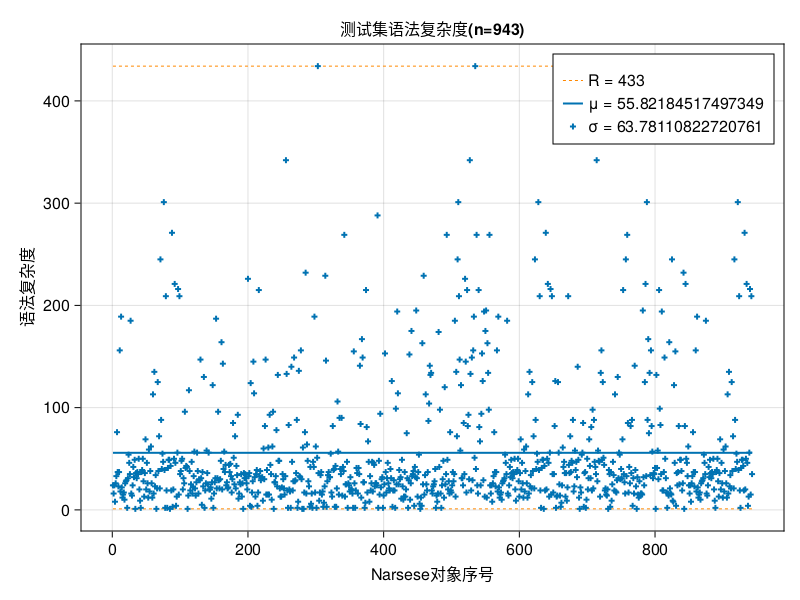

In [23]:
# 测试集情况
fig = Figure()
ax = Axis(fig[1, 1])

let 
    # 计算结果
    xs = 1:length(test_set.complexity)
    ys = test_set.complexity
    
    μ_y = sum(ys) / length(ys)
    σ_y = √(sum((ys .- μ_y) .^ 2) / length(ys)) # 【20230816 21:22:20】使用根号√计算方根
    max_y = max(ys...)
    min_y = min(ys...)
    one_ys = ones(length(ys))
    
    # 绘制最大、最小值
    l = lines!(
        ax, xs, max_y * one_ys; 
        label = "R = $(max_y-min_y)",
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = "0xff8800",
    )
    lines!(
        ax, xs, min_y * one_ys; 
        linewidth = 1,
        linestyle = :dash, # 虚线
        color = l.color, # 复用颜色
    )
    # 绘制均值一条线
    lines!(
        ax, xs, μ_y * one_ys; 
        label = "μ = $μ_y",
        linewidth = 2,
        linestyle = nothing,
    )
    # 绘制散点图
    sl = scatterlines!(
        ax, xs, ys;
        label = "σ = $σ_y",
        linewidth = 0,
        markersize = 8,
        marker = :+,
    )
end

# 后期表格修饰
axislegend(""; position=:rt)
ax.title = "测试集语法复杂度(n=$(size(test_set, 1)))"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "语法复杂度"

current_figure()

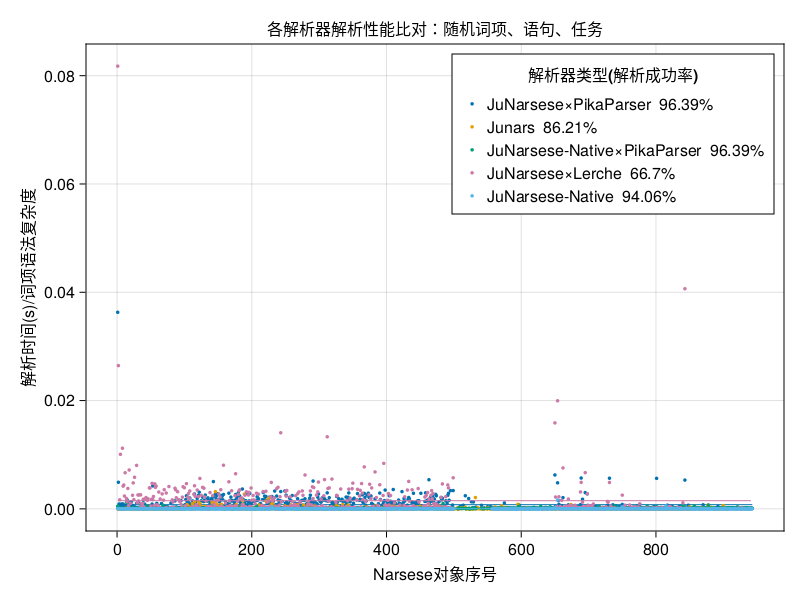

In [24]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    N = length(result.time)
    # 计算结果
    data = DataFrame(
        x = 1:N,
        y = result.time ./ result.complexity
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_y = sum(data.y) / length(data.y)
    mean_ys = mean_y * ones(length(data.y))
    lines!(
        ax, data.x, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "解析时间(s)/词项语法复杂度"

current_figure()

μₜ(JuNarsese×PikaParser) = -3.4747193791347297
μₜ(Junars) = -4.843969205782262
μₜ(JuNarsese-Native×PikaParser) = -4.020561315141618
μₜ(JuNarsese×Lerche) = -3.387111210724357
μₜ(JuNarsese-Native) = -4.67409258156859


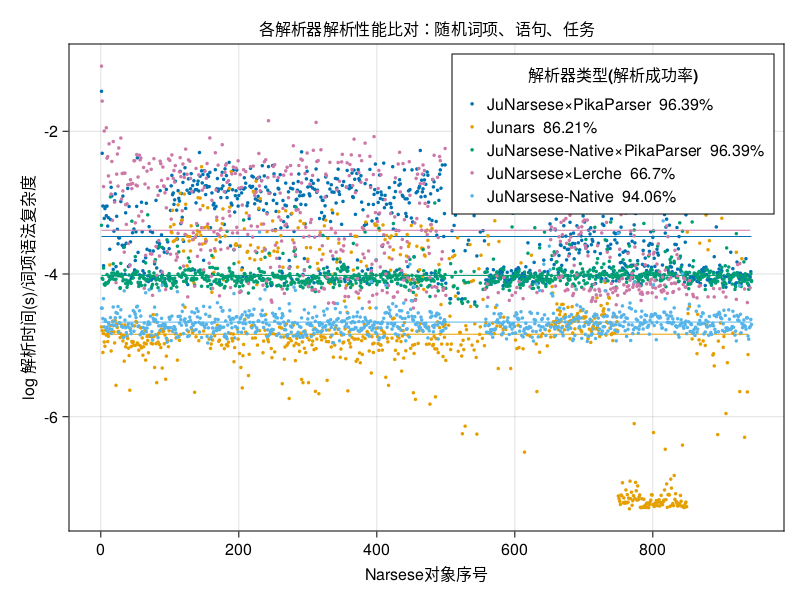

In [25]:
# 使用CairoMakie打印其中的「解析时间线」
fig = Figure()
ax = Axis(fig[1, 1])
for (parser, result) in results
    # 计算结果
    data = DataFrame(
        x = 1:length(result.time),
        y = log10.(result.time ./ result.complexity)
    )
    # 过滤
    filter!(
        :y => y -> !ismissing(y) && !isnothing(y) && !isnan(y) && isfinite(y),
        data,
    )
    xs, ys = data.x, data.y
    success_count = count((!ismissing).(result.time))
    complete_pct = string(round(success_count/N*100, digits=2), "%")
    # 散点
    sl = scatter!(
        ax, data.x, data.y;
        label = "$(parser_names[parser])\t$complete_pct",
        # color = :black,
        markersize = 5,
    )
    # 绘制均值一条线
    mean_ys = sum(ys) / length(ys)
    "μₜ($(parser_names[parser])) = $mean_ys" |> println
    mean_ys = mean_ys * ones(length(ys))
    lines!(
        ax, xs, mean_ys; 
        # color = :black, 
        linewidth = 1
    )
end

# 后期表格修饰
axislegend("解析器类型(解析成功率)"; position=:rt)
ax.title = "各解析器解析性能比对：随机词项、语句、任务"
ax.xlabel = "Narsese对象序号"
ax.ylabel = "log 解析时间(s)/词项语法复杂度"

current_figure()